# Converting ATN netCDF file to Dawrin Core

Created: 2022-03-23

This notebook walks through downloading an example netCDF file from the ATN GitHub repository and translating it to a Darwin Core Archive compliant package for easy loading and publishing via the Integrated Publishing Toolkit (IPT). The example file follows a specific specification for ATN satellite trajectory observations as documented [here](https://github.com/ioos/ioos-atn-data/blob/main/templates/atn_trajectory_template.cdl). More information about the ATN netCDF specification can be found in the repository https://github.com/ioos/ioos-atn-data.

Since most of the examples in the IOOS Code Lab are in the python programming language, we wanted to show an example of working with a netCDF file in the R programming language to be inclusive of those users. 

For more information on the tidync package, see this R blog: [https://ropensci.org/blog/2019/11/05/tidync/](https://ropensci.org/blog/2019/11/05/tidync/)

**Caution** This notebook uses an example file for testing purposes. The data contained in the file are **not real**, they are within normal bounds to give a perspective of what the observations could look like.

In [1]:
library(tidync)

In [2]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19044)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tidync_0.3.0

loaded via a namespace (and not attached):
 [1] magrittr_2.0.3   tidyselect_1.2.0 uuid_1.1-0       R6_2.5.1        
 [5] rlang_1.1.1      fastmap_1.1.1    fansi_1.0.4      dplyr_1.1.2     
 [9] tools_4.1.3      utf8_1.2.3       ncmeta_0.3.5     cli_3.6.1       
[13] htmltools_0.5.6  digest_0.6.33    tibble_3.2.1     lifecycle_1.0.3 
[17] RNetCDF_2.6-2    crayon_1.5.2     IRdisplay_1.1    purrr_1.0.2     
[21] repr_1.1.6       base64enc_0.1-3  vctrs_0.6.3      ncdf4_1.21      
[25] IRkern

## Download the netCDF file from the GitHub repository

In [3]:
url = 'https://ncei.axiomdatascience.com/atn/shark-101/atn_45866_great-white-shark_trajectory_20090923-20091123.nc'
download.file(url, 'atn_trajectory_template.nc', mode = "wb")

## Open the netCDF file
Once the file is opened, we print out the details of what the netCDF file contains.

In [43]:
atn <- tidync("atn_trajectory_template.nc")
atn


Data Source (1): atn_trajectory_template.nc ...

Grids (1) <dimension family> : <associated variables> 

[1]   D0 : time, z, lat, lon, ptt, instrument, type, location_class, error_radius, semi_major_axis, semi_minor_axis, ellipse_orientation, offset, offset_orientation, gpe_msd, gpe_u, count, qartod_time_flag, qartod_speed_flag, qartod_location_flag, qartod_rollup_flag, comment    **ACTIVE GRID** ( 29  values per variable)

Dimensions 1 (all active): 
  
  dim   name  length   min   max start count  dmin  dmax unlim coord_dim 
  <chr> <chr>  <dbl> <dbl> <dbl> <int> <int> <dbl> <dbl> <lgl> <lgl>     
1 D0    obs       29     1    29     1    29     1    29 FALSE FALSE     

In [54]:
hyper_tibble(atn, select_var="animal", raw_datavals=TRUE)

ERROR: Error in hyper_array.tidync(x, ..., force = force): no select_var variables available


## Collect all the metadata from the netCDF file.

This gathers not only the global attributes, but the variable level attributes as well. As you can see in the **variable** column the term `NC_GLOBAL` refers to global attributes.

In [5]:
metadata <- ncmeta::nc_atts("atn_trajectory_template.nc")
metadata

id,name,variable,value
<int>,<chr>,<chr>,<named list>
0,long_name,deploy_id,id for this deployment. This is typically the tag ptt
1,comment,deploy_id,"Friendly name given to the tag by the user. If no specific friendly name is given, this is the PTT id."
2,coordinates,deploy_id,time z lon lat
3,instrument,deploy_id,instrument_location
4,platform,deploy_id,animal
5,coverage_content_type,deploy_id,referenceInformation
6,_FillValue,deploy_id,-9999
0,units,time,seconds since 1990-01-01 00:00:00Z
1,standard_name,time,time


## Example extracting `long_name` attributes

To give you an idea of what observations are in this file, we can print out the human readable `long_name` attribute from all the variables.

In [6]:
metadata %>% dplyr::filter(name == "long_name")

id,name,variable,value
<int>,<chr>,<chr>,<named list>
0,long_name,deploy_id,id for this deployment. This is typically the tag ptt
5,long_name,time,"Time of the measurement, in seconds since 1970-01-01"
2,long_name,z,depth of measurement
2,long_name,lat,Latitude portion of location in decimal degrees North
2,long_name,lon,Longitude portion of location in decimal degrees East
2,long_name,ptt,Platform Transmitter Terminal (PTT) id used for Argos transmissions
2,long_name,instrument,Instrument family
2,long_name,type,"Type of location information - Argos, GPS satellite or user provided location"
3,long_name,location_class,Location Quality Code from ARGOS satellite system


## Store the data as a tibble in a variable
Collect the data dimensioned by `time` from the netCDF file as a tibble. Then, print the first ten rows.

In [7]:
options(repr.matrix.max.cols=35)

atn_tbl <- atn %>% hyper_tibble(force=TRUE)

atn_tbl

time,z,lat,lon,ptt,instrument,type,location_class,error_radius,semi_major_axis,semi_minor_axis,ellipse_orientation,offset,offset_orientation,gpe_msd,gpe_u,count,qartod_time_flag,qartod_speed_flag,qartod_location_flag,qartod_rollup_flag,comment,obs
<dbl>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
622512000,0,34.030,-118.560,45866,SPOT,User,nan,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,2,1,1,,1
622708920,0,23.590,-166.180,45866,SPOT,Argos,A,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,4,1,4,,2
622724940,0,34.024,-118.556,45866,SPOT,Argos,1,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,4,1,4,,3
622725060,0,34.035,-118.549,45866,SPOT,Argos,0,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,4,1,4,,4
622922280,0,34.033,-118.547,45866,SPOT,Argos,1,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,1,1,1,,5
623134860,0,33.517,-119.750,45866,SPOT,Argos,B,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,1,1,1,,6
623881440,0,34.038,-118.581,45866,SPOT,Argos,2,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,1,1,1,,7
624452700,0,33.995,-118.678,45866,SPOT,Argos,0,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,1,1,1,,8
624607860,0,34.037,-118.545,45866,SPOT,Argos,0,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,1,1,1,,9


## Dealing with time

Notice the data in the **time** column aren't formatted as times. We need to read the metadata associated with the time variable to understand what the units are. Below, we print a tibble of all the attributes from the **time** variable.

Notice the _units_ attribute and it's value of `seconds since 1990-01-01 00:00:00Z`. We need to use that information to convert the time variable to something useful that `ggplot` can handle.

In [8]:
time_attrs <- metadata %>% dplyr::filter(variable == "time")
time_attrs

id,name,variable,value
<int>,<chr>,<chr>,<named list>
0,units,time,seconds since 1990-01-01 00:00:00Z
1,standard_name,time,time
2,axis,time,T
3,_CoordinateAxisType,time,Time
4,calendar,time,standard
5,long_name,time,"Time of the measurement, in seconds since 1970-01-01"
6,actual_min,time,2009-09-23T00:00:00Z
7,actual_max,time,2009-11-23T05:12:00Z
8,ancillary_variables,time,qartod_time_flag qartod_rollup_flag qartod_speed_flag


So, we grab the value from the `units` attribute, split the string to collect the date information, and apply that to a time conversion function `as.POSIXct`.

In [9]:
library(stringr)
# grab origin date from time variable units attribute
tunit <- time_attrs %>% dplyr::filter(name == "units")
lunit <- str_split(tunit$value,' ')[[1]]
atn_tbl$time <- as.POSIXct(atn_tbl$time, origin=lunit[3], tz="GMT")

atn_tbl

time,z,lat,lon,ptt,instrument,type,location_class,error_radius,semi_major_axis,semi_minor_axis,ellipse_orientation,offset,offset_orientation,gpe_msd,gpe_u,count,qartod_time_flag,qartod_speed_flag,qartod_location_flag,qartod_rollup_flag,comment,obs
<dttm>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
2009-09-23 00:00:00,0,34.030,-118.560,45866,SPOT,User,nan,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,2,1,1,,1
2009-09-25 06:42:00,0,23.590,-166.180,45866,SPOT,Argos,A,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,4,1,4,,2
2009-09-25 11:09:00,0,34.024,-118.556,45866,SPOT,Argos,1,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,4,1,4,,3
2009-09-25 11:11:00,0,34.035,-118.549,45866,SPOT,Argos,0,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,4,1,4,,4
2009-09-27 17:58:00,0,34.033,-118.547,45866,SPOT,Argos,1,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,1,1,1,,5
2009-09-30 05:01:00,0,33.517,-119.750,45866,SPOT,Argos,B,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,1,1,1,,6
2009-10-08 20:24:00,0,34.038,-118.581,45866,SPOT,Argos,2,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,1,1,1,,7
2009-10-15 11:05:00,0,33.995,-118.678,45866,SPOT,Argos,0,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,1,1,1,,8
2009-10-17 06:11:00,0,34.037,-118.545,45866,SPOT,Argos,0,NA,NA,NA,NA,NA,NA,NaN,NaN,NA,1,1,1,1,,9


## Plotting the data

Now lets make some plots just to take a look at what data we're working with. Here we make a plot of time vs longitude.

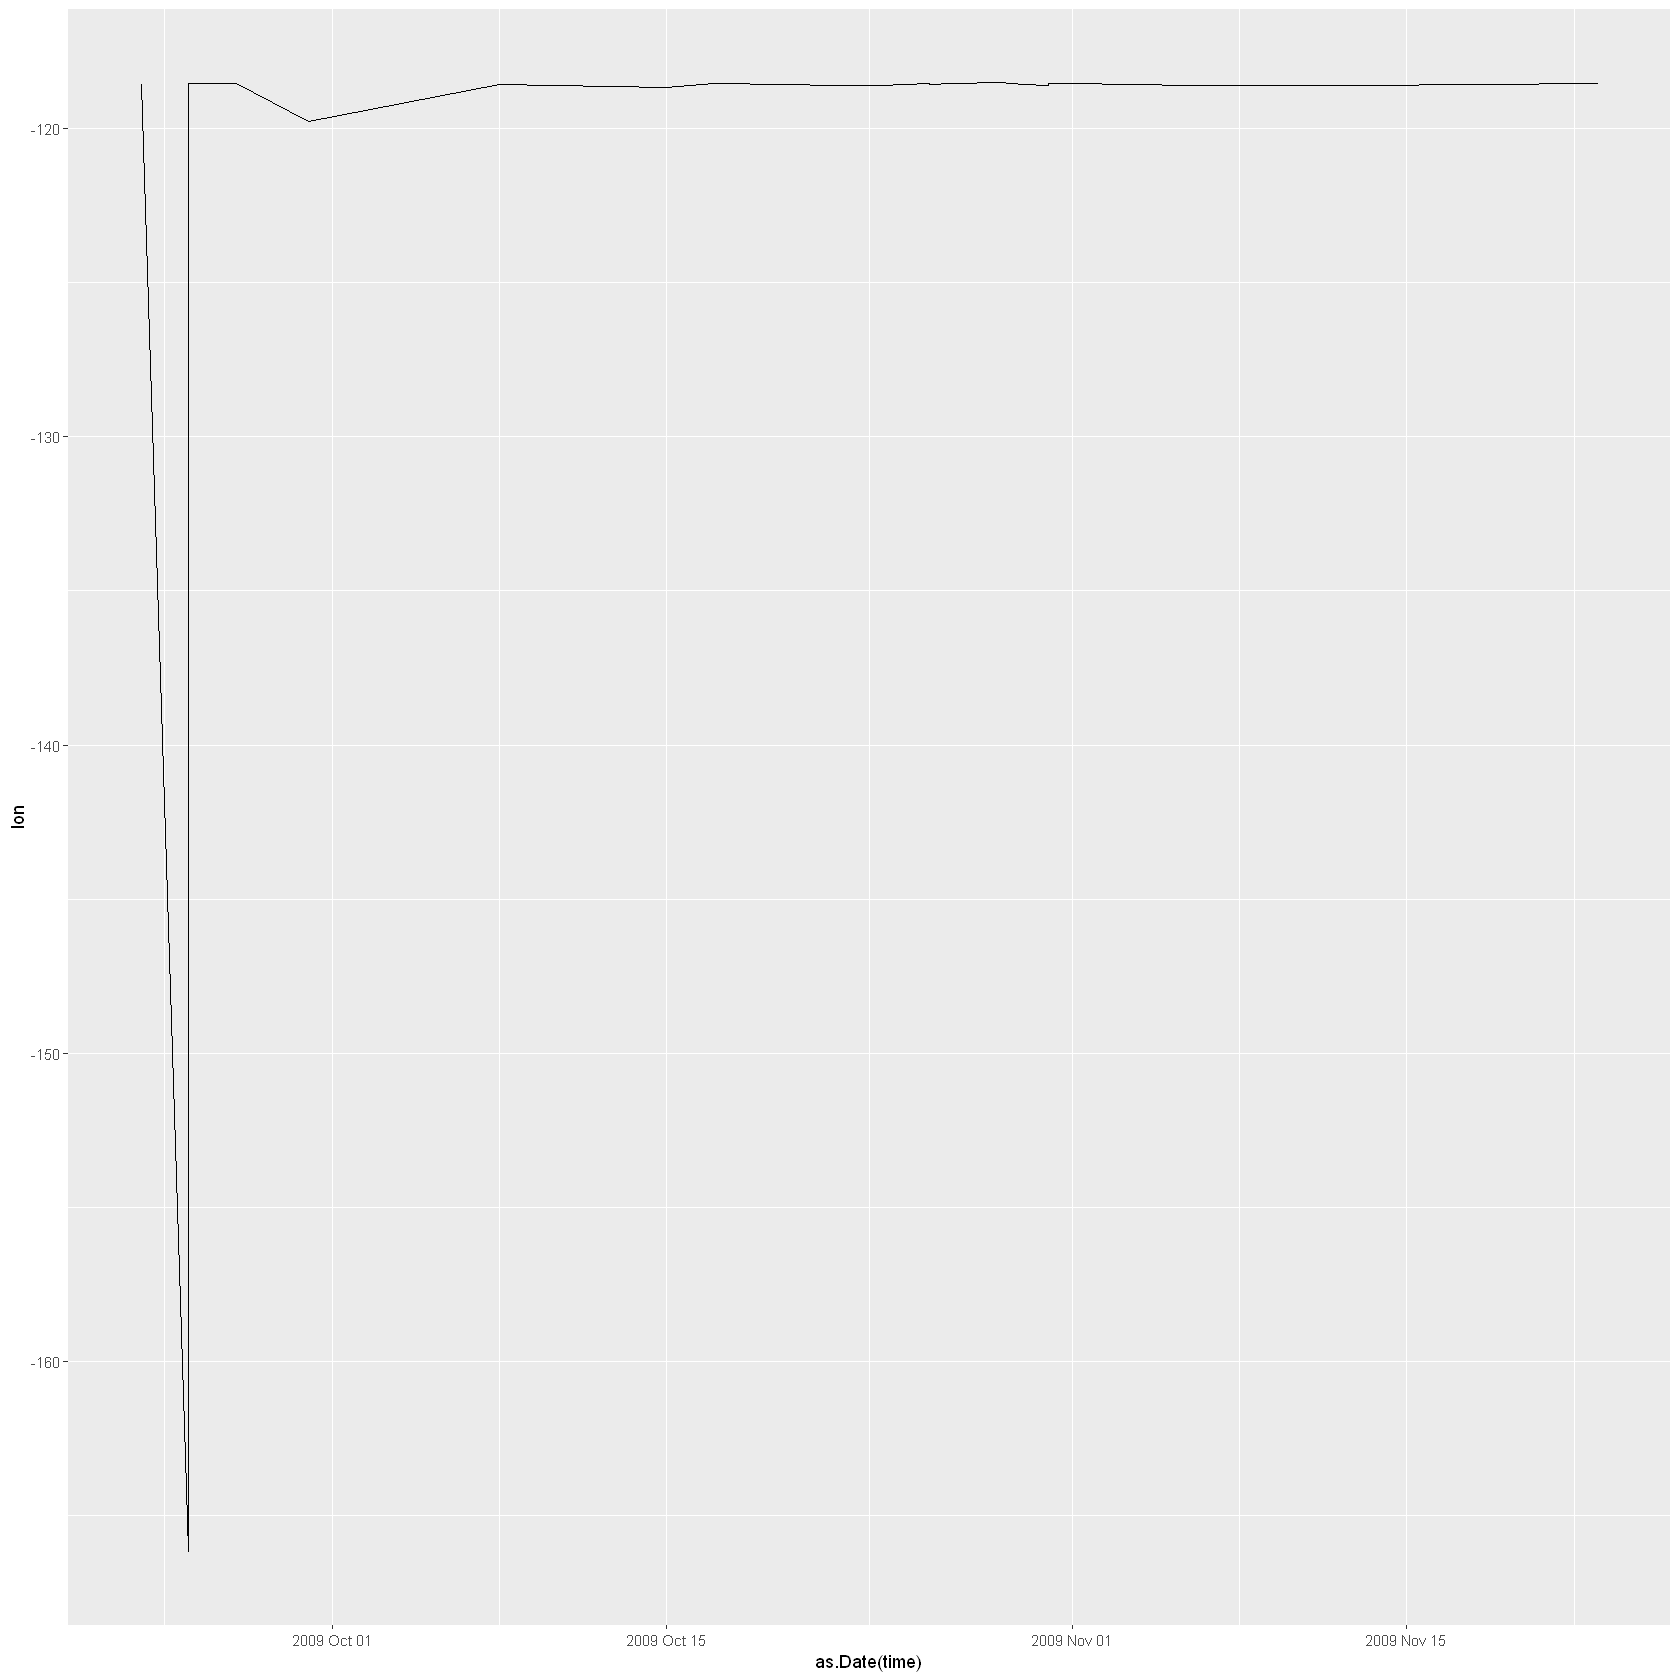

In [10]:
library(ggplot2)

options(repr.plot.width = 14, repr.plot.height = 14)

ggplot(atn_tbl, aes(x=as.Date(time), y=lon)) + 
    geom_line() + 
    scale_x_date(date_labels = "%Y %b %d")

## Making a map

Next, let's make a map of the locations of this animal with the colors dependent on time.

Use the global attribute `title` as the title of the plot.

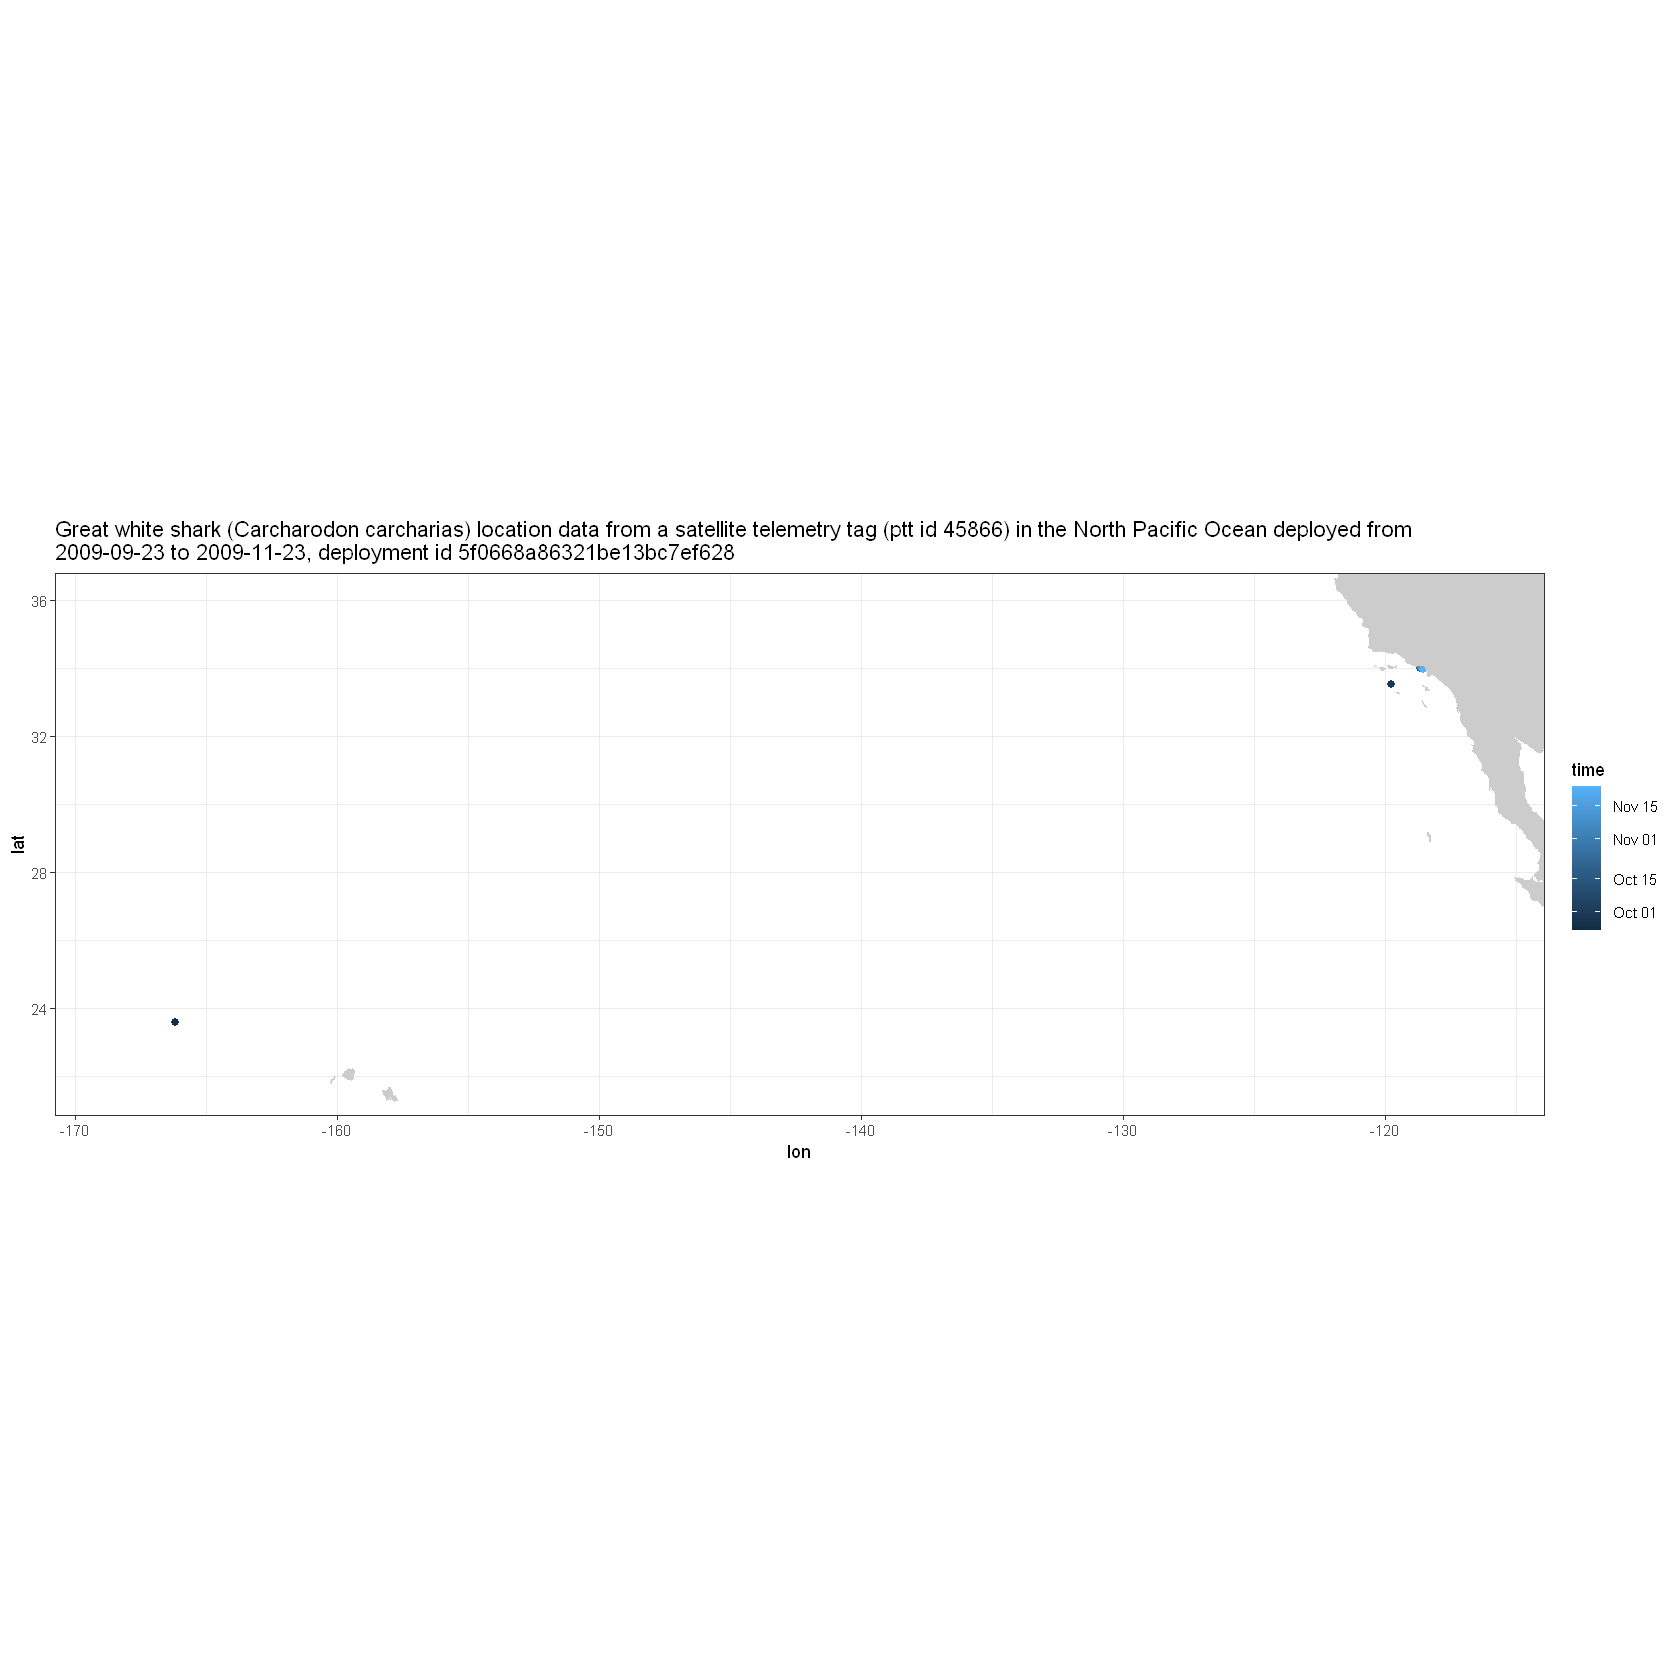

In [11]:
library('maps')
library('mapdata')

# collect title from global attributes
title <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "title")


# Map limits.
ylim <- c( min(atn_tbl$lat)-2, max(atn_tbl$lat)+2 )
xlim <- c( min(atn_tbl$lon)-2, max(atn_tbl$lon)+2 )

# Get outline data for map.
w <- map_data( 'worldHires', ylim = ylim, xlim = xlim )

z <- ggplot(atn_tbl, aes( x = lon, y = lat )) +
     geom_point( aes(colour = time), size = 2.0) +
     scale_shape_manual( values = c(19, 1) )

z + geom_polygon(data = w, aes(x = long, y = lat, group = group), fill = 'grey80') + 
    theme_bw() +
    coord_fixed(1.3, xlim = xlim, ylim = ylim) + 
    ggtitle( paste( strwrap(title$value, width = 150), collapse = "\n") )

---
# Converting to Darwin Core

Now let's work through converting this netCDF file to Darwin Core. Following the guidance published at https://github.com/tdwg/dwc-for-biologging/wiki/Data-guidelines and https://github.com/ocean-tracking-network/biologging_standardization/tree/master/examples/braun-blueshark/darwincore-example

Luckily we've already done the mappings in [this spreadsheet](https://docs.google.com/spreadsheets/d/12pP4IY2oXFhkXvOePtizHnShhlmO0r7QOTxu5ETvNOA/edit#gid=0).

## Event Core
Term | Status
-----|-------
eventID | Required
eventDate | Required
decimalLatitude & decimalLongitude | Required
geodeticDatum | Required
locationID | Strongly Recommended
maximumDepthInMeters & minimumDepthInMeters | Strongly Recommended
footprintWKT | Share if available
modified | Share if available

In [12]:
tag_id <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "ptt_id")
tag_id

id,name,variable,value
<int>,<chr>,<chr>,<named list>
77,ptt_id,NC_GLOBAL,45866


## Create a data frame with time, latitude, longitude, and depth

In [13]:
# for Event Core following: 
# https://github.com/tdwg/dwc-for-biologging/wiki/Data-guidelines#event-core

eventdf <- data.frame( atn_tbl$time, atn_tbl$lat, atn_tbl$lon, atn_tbl$z)

# eventID
# urn:catalog:[datacenter]:[institution]:[project shortcode]:[datacenter-specific-ID] 
# At OTN, the datacenter-specific ID is a combination of the animal's identifier, project affiliation, 
# and the date of release. e.g. urn:catalog:otn:DAL:NSBS:NSBS-Hops:20170722053000-release
#
# institution <- ncmeta::nc_atts("atn_trajectory_template.nc","NC_GLOBAL") %>% dplyr::filter(name == "institution")
# project_shortcode <- 'atn'
# datacenter_specific_ID <- ncmeta::nc_atts("atn_trajectory_template.nc","NC_GLOBAL") %>% dplyr::filter(name == "tag_id")
#
# id <- paste("urn:catalog:atn",institution$value,project_shortcode,datacenter_specific_ID$value, sep = ":")

uuid_tbl = metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "uuid")
eventdf$eventID <- paste(uuid_tbl$value)

#eventDate
eventdf$eventDate <- format(eventdf$atn_tbl.time, '%Y-%m-%dT%H:%M:%SZ')
eventdf$atn_tbl.time <- NULL

#decimalLatitude
eventdf$decimalLatitude <- eventdf$atn_tbl.lat
eventdf$atn_tbl.lat <- NULL

#decimalLongitude
eventdf$decimalLongitude <- eventdf$atn_tbl.lon
eventdf$atn_tbl.lon <- NULL

#geodeticDatum
gd_tbl <- metadata %>% dplyr::filter(variable == "crs") %>% dplyr::filter(name == "epsg_code")
eventdf$geodeticDatum <- paste(gd_tbl$value)

#maximumDepth and minimumDepth
eventdf$minimumDepthInMeters <- eventdf$atn_tbl.z
eventdf$maximumDepthInMeters <- eventdf$atn_tbl.z
eventdf$atn_tbl.z <- NULL

#locationID
eventdf$locationID <- 'Release' # from https://github.com/tdwg/dwc-for-biologging/wiki/Acoustic-sensor-enabled-tracking-of-blue-sharks

#footprintWKT
ftprnt_tbl = metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "geospatial_bounds")
eventdf$footprintWKT <- paste(ftprnt_tbl$value)

#modified
mdfied_tbl <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "date_modified")
eventdf$modified <- paste(mdfied_tbl$value)

head(eventdf, n=10)

,eventID,eventDate,decimalLatitude,decimalLongitude,geodeticDatum,minimumDepthInMeters,maximumDepthInMeters,locationID,footprintWKT,modified
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,2009-09-23T00:00:00Z,34.030,-118.560,EPSG:4326,0,0,Release,"POLYGON ((-166.18 23.59, -118.581 34.038, -118.53 34.045, -118.504 33.989, -118.534 33.972, -119.75 33.517, -166.18 23.59))",2023-08-07T21:03:13Z
2,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,2009-09-25T06:42:00Z,23.590,-166.180,EPSG:4326,0,0,Release,"POLYGON ((-166.18 23.59, -118.581 34.038, -118.53 34.045, -118.504 33.989, -118.534 33.972, -119.75 33.517, -166.18 23.59))",2023-08-07T21:03:13Z
3,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,2009-09-25T11:09:00Z,34.024,-118.556,EPSG:4326,0,0,Release,"POLYGON ((-166.18 23.59, -118.581 34.038, -118.53 34.045, -118.504 33.989, -118.534 33.972, -119.75 33.517, -166.18 23.59))",2023-08-07T21:03:13Z
4,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,2009-09-25T11:11:00Z,34.035,-118.549,EPSG:4326,0,0,Release,"POLYGON ((-166.18 23.59, -118.581 34.038, -118.53 34.045, -118.504 33.989, -118.534 33.972, -119.75 33.517, -166.18 23.59))",2023-08-07T21:03:13Z
5,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,2009-09-27T17:58:00Z,34.033,-118.547,EPSG:4326,0,0,Release,"POLYGON ((-166.18 23.59, -118.581 34.038, -118.53 34.045, -118.504 33.989, -118.534 33.972, -119.75 33.517, -166.18 23.59))",2023-08-07T21:03:13Z
6,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,2009-09-30T05:01:00Z,33.517,-119.750,EPSG:4326,0,0,Release,"POLYGON ((-166.18 23.59, -118.581 34.038, -118.53 34.045, -118.504 33.989, -118.534 33.972, -119.75 33.517, -166.18 23.59))",2023-08-07T21:03:13Z
7,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,2009-10-08T20:24:00Z,34.038,-118.581,EPSG:4326,0,0,Release,"POLYGON ((-166.18 23.59, -118.581 34.038, -118.53 34.045, -118.504 33.989, -118.534 33.972, -119.75 33.517, -166.18 23.59))",2023-08-07T21:03:13Z
8,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,2009-10-15T11:05:00Z,33.995,-118.678,EPSG:4326,0,0,Release,"POLYGON ((-166.18 23.59, -118.581 34.038, -118.53 34.045, -118.504 33.989, -118.534 33.972, -119.75 33.517, -166.18 23.59))",2023-08-07T21:03:13Z
9,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,2009-10-17T06:11:00Z,34.037,-118.545,EPSG:4326,0,0,Release,"POLYGON ((-166.18 23.59, -118.581 34.038, -118.53 34.045, -118.504 33.989, -118.534 33.972, -119.75 33.517, -166.18 23.59))",2023-08-07T21:03:13Z


### Write the event file as a csv

In [14]:
file_name_event <- paste('atn_',tag_id$value,'_event.csv', sep = "")

write.csv(eventdf, file=file_name_event, row.names=FALSE, fileEncoding="UTF-8", quote=TRUE)

## Occurrence Core
Term | Status
-----|------
basisOfRecord | Required
occurrenceID | Required
organismID | Required
eventDate | Required
decimalLatitude & decimalLongitude | Required
geodeticDatum | Required
scientificName | Required
eventID | Strongly recommended
samplingProtocol | Strongly recommended
kingdom | Strongly recommended
taxonRank | Strongly recommended
coordinateUncertaintyInMeters | Share if available

In [15]:
options(repr.matrix.max.rows=91)

globals <- metadata %>% dplyr::filter(variable == "NC_GLOBAL")

globals

id,name,variable,value
<int>,<chr>,<chr>,<named list>
0,date_created,NC_GLOBAL,2023-08-07T21:03:13Z
1,featureType,NC_GLOBAL,trajectory
2,cdm_data_type,NC_GLOBAL,Trajectory
3,Conventions,NC_GLOBAL,"CF-1.10, ACDD-1.3, IOOS-1.2"
4,argos_program_number,NC_GLOBAL,2414
5,creator_email,NC_GLOBAL,chris.lowe@csulb.edu
6,id,NC_GLOBAL,5f0668a86321be13bc7ef628
7,tag_type,NC_GLOBAL,SPOT5
8,source,NC_GLOBAL,Service Argos


In [16]:
# occurrence Core/Extension

occurrencedf <- data.frame( atn_tbl$time, atn_tbl$lat, atn_tbl$lon)

# basisOfRecord
occurrencedf$basisOfRecord <- 'machineObservation'

# organismID
# platformID + common name
common_name_tbl <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "animal_common_name")
platform_id_tbl <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "platform_id")
occurrencedf$organismID <- paste(platform_id_tbl$value, common_name_tbl$value, sep = "_")

# eventDate
occurrencedf$eventDate <- format(occurrencedf$atn_tbl.time, '%Y-%m-%dT%H:%M:%SZ')
occurrencedf$atn_tbl.time <- NULL

# occurrenceID
rank_tbl <- metadata %>% dplyr::filter(variable == "animal") %>% dplyr::filter(name == "rank")
occurrencedf$occurrenceID <- paste(occurrencedf$eventDate, atn_tbl$z, rank_tbl$value, sep = "_")

#decimalLatitude
occurrencedf$decimalLatitude <- occurrencedf$atn_tbl.lat
occurrencedf$atn_tbl.lat <- NULL

#decimalLongitude
occurrencedf$decimalLongitude <- occurrencedf$atn_tbl.lon
occurrencedf$atn_tbl.lon <- NULL

# geodeticDatum
gd_tbl <- metadata %>% dplyr::filter(variable == "crs") %>% dplyr::filter(name == "epsg_code")
occurrencedf$geodeticDatum <- paste(gd_tbl$value)

# scientificName
occurrencedf$scientificName <- RNetCDF::var.get.nc(RNetCDF::open.nc("atn_trajectory_template.nc"), "taxon_name")

# scientificNameId
# value of taxon_lsid var
occurrencedf$scientificNameId <- RNetCDF::var.get.nc(RNetCDF::open.nc("atn_trajectory_template.nc"), "taxon_lsid")

# eventID
uuid_tbl = metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "uuid")
occurrencedf$eventID <- paste(uuid_tbl$value)

# samplingProtocol
# don't have a mapping yet


# kingdom
kingdom_tbl <- metadata %>% dplyr::filter(variable == "animal") %>% dplyr::filter(name == "kingdom")
occurrencedf$kingdom <- paste(kingdom_tbl$value)

# taxonRank
occurrencedf$taxonRank <- paste(rank_tbl$value)

# coordinateUncertaintyInMeters
# take the larger of variable:error_radius AND variable:semi_major_axis
occurrencedf$coordinateUncertaintyInMeters <- pmax(atn_tbl$error_radius, atn_tbl$semi_major_axis, atn_tbl$semi_minor_axis, na.rm = TRUE)

head(occurrencedf, n=10)

,basisOfRecord,organismID,eventDate,occurrenceID,decimalLatitude,decimalLongitude,geodeticDatum,scientificName,scientificNameId,eventID,kingdom,taxonRank,coordinateUncertaintyInMeters
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,machineObservation,105838_great white shark,2009-09-23T00:00:00Z,2009-09-23T00:00:00Z_0_Species,34.030,-118.560,EPSG:4326,Carcharodon carcharias,urn:lsid:marinespecies.org:taxname:105838,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,Animalia,Species,NA
2,machineObservation,105838_great white shark,2009-09-25T06:42:00Z,2009-09-25T06:42:00Z_0_Species,23.590,-166.180,EPSG:4326,Carcharodon carcharias,urn:lsid:marinespecies.org:taxname:105838,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,Animalia,Species,NA
3,machineObservation,105838_great white shark,2009-09-25T11:09:00Z,2009-09-25T11:09:00Z_0_Species,34.024,-118.556,EPSG:4326,Carcharodon carcharias,urn:lsid:marinespecies.org:taxname:105838,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,Animalia,Species,NA
4,machineObservation,105838_great white shark,2009-09-25T11:11:00Z,2009-09-25T11:11:00Z_0_Species,34.035,-118.549,EPSG:4326,Carcharodon carcharias,urn:lsid:marinespecies.org:taxname:105838,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,Animalia,Species,NA
5,machineObservation,105838_great white shark,2009-09-27T17:58:00Z,2009-09-27T17:58:00Z_0_Species,34.033,-118.547,EPSG:4326,Carcharodon carcharias,urn:lsid:marinespecies.org:taxname:105838,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,Animalia,Species,NA
6,machineObservation,105838_great white shark,2009-09-30T05:01:00Z,2009-09-30T05:01:00Z_0_Species,33.517,-119.750,EPSG:4326,Carcharodon carcharias,urn:lsid:marinespecies.org:taxname:105838,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,Animalia,Species,NA
7,machineObservation,105838_great white shark,2009-10-08T20:24:00Z,2009-10-08T20:24:00Z_0_Species,34.038,-118.581,EPSG:4326,Carcharodon carcharias,urn:lsid:marinespecies.org:taxname:105838,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,Animalia,Species,NA
8,machineObservation,105838_great white shark,2009-10-15T11:05:00Z,2009-10-15T11:05:00Z_0_Species,33.995,-118.678,EPSG:4326,Carcharodon carcharias,urn:lsid:marinespecies.org:taxname:105838,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,Animalia,Species,NA
9,machineObservation,105838_great white shark,2009-10-17T06:11:00Z,2009-10-17T06:11:00Z_0_Species,34.037,-118.545,EPSG:4326,Carcharodon carcharias,urn:lsid:marinespecies.org:taxname:105838,ff554ebf-bf4b-5a82-8a90-9c0ceb799d96,Animalia,Species,NA


### Write occurrence file as csv

In [17]:
file_name_occur <- paste('atn_',tag_id$value,'_occurrence.csv', sep = "")

write.csv(occurrencedf, file=file_name_occur, row.names=FALSE, fileEncoding="UTF-8", quote=TRUE)

## Measurement or Fact

Since we don't have any additional observations, we are not creating a measurement or fact file. Might be worthwhile to include tag/device metadata, some of the animal measurements, and the detachment information. Each term should have a definition URI.

Term | Status
-----|-----
occurrenceID | Required
measurementType | Required
measurementValue | Required
eventID	| Strongly Recommended
measurementUnit | Strongly Recommended
measurementMethod | Strongly Recommended
measurementTypeID | Strongly Recommended
measurementMethodID | Strongly Recommended
measurementUnitID | Strongly Recommended
measurementAccuracy | Share if available
measurementDeterminedDate | Share if available
measurementDeterminedBy | Share if available
measurementRemarks | Share if available
measurementValueID | Share if available

In [18]:
# Measurement or Fact extension

mofdf <- atn_tbl

# Initial checks

Now that we have our data frames organized as we think they should be for loading into the IPT and publishing, let's do some initial checks on the data to make sure we pass the sniff test.

Here we use two packages to check out the data:
1. [obistools](https://iobis.github.io/obistools/index.html)
1. [Hmisc](https://cran.r-project.org/web/packages/Hmisc/index.html)

In [19]:
library(obistools)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

rgeos version: 0.6-3, (SVN revision 696)
 GEOS runtime version: 3.11.2-CAPI-1.17.2 
 Please note that rgeos will be retired during October 2023,
plan transition to sf or terra functions using GEOS at your earliest convenience.
See https://r-spatial.org/r/2023/05/15/evolution4.html for details.
 GEOS using OverlayNG
 Linking to sp version: 1.6-1 
 Polygon checking: TRUE 




First, we will use `obistools::report` to create a report for the occurrence data frame.

In [20]:
report <- obistools::report(occurrencedf)
report

Warning message:
"`data_frame()` was deprecated in tibble 1.1.0.
i Please use `tibble()` instead.
i The deprecated feature was likely used in the obistools package.
  Please report the issue to the authors."


processing file: report.Rmd



1/7                  
2/7 [unnamed-chunk-1]
3/7                  
4/7 [unnamed-chunk-2]
5/7                  
6/7 [unnamed-chunk-3]
7/7                  


output file: report.knit.md




"C:/Users/MATHEW~1.BID/programs/MINIFO~1/envs/IOOS/Library/bin/pandoc" +RTS -K512m -RTS report.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc40c47650a14.html --lua-filter "C:\Users\Mathew.Biddle\programs\Miniforge3\envs\IOOS\Lib\R\library\rmarkdown\rmarkdown\lua\pagebreak.lua" --lua-filter "C:\Users\Mathew.Biddle\programs\Miniforge3\envs\IOOS\Lib\R\library\rmarkdown\rmarkdown\lua\latex-div.lua" --embed-resources --standalone --variable bs3=TRUE --section-divs --template "C:\Users\Mathew.Biddle\programs\Miniforge3\envs\IOOS\Lib\R\library\rmarkdown\rmd\h\default.html" --no-highlight --variable highlightjs=1 --variable theme=bootstrap --mathjax --variable "mathjax-url=https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML" --include-in-header "C:\Users\MATHEW~1.BID\AppData\Local\Temp\1\RtmpiyndfU\rmarkdown-str40c459544d63.html" 



Output created: C:/Users/Mathew.Biddle/AppData/Local/obistools/obistools/Cache/report.html



[1] "C:/Users/Mathew.Biddle/AppData/Local/obistools/obistools/Cache/report.html"

Next, we will create a report for the event data frame.

In [21]:
event_report <- obistools::report(eventdf)
event_report



processing file: report.Rmd



1/7                  
2/7 [unnamed-chunk-1]
3/7                  
4/7 [unnamed-chunk-2]
5/7                  
6/7 [unnamed-chunk-3]
7/7                  


output file: report.knit.md




"C:/Users/MATHEW~1.BID/programs/MINIFO~1/envs/IOOS/Library/bin/pandoc" +RTS -K512m -RTS report.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc40c452497181.html --lua-filter "C:\Users\Mathew.Biddle\programs\Miniforge3\envs\IOOS\Lib\R\library\rmarkdown\rmarkdown\lua\pagebreak.lua" --lua-filter "C:\Users\Mathew.Biddle\programs\Miniforge3\envs\IOOS\Lib\R\library\rmarkdown\rmarkdown\lua\latex-div.lua" --embed-resources --standalone --variable bs3=TRUE --section-divs --template "C:\Users\Mathew.Biddle\programs\Miniforge3\envs\IOOS\Lib\R\library\rmarkdown\rmd\h\default.html" --no-highlight --variable highlightjs=1 --variable theme=bootstrap --mathjax --variable "mathjax-url=https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML" --include-in-header "C:\Users\MATHEW~1.BID\AppData\Local\Temp\1\RtmpiyndfU\rmarkdown-str40c450e142eb.html" 



Output created: C:/Users/Mathew.Biddle/AppData/Local/obistools/obistools/Cache/report.html



[1] "C:/Users/Mathew.Biddle/AppData/Local/obistools/obistools/Cache/report.html"

Finally, we will use `hmisc::describe` to inspect the data frames for any potential issues.

In [22]:
Hmisc::describe(occurrencedf)

occurrencedf 

 13  Variables      29  Observations
--------------------------------------------------------------------------------
basisOfRecord 
                 n            missing           distinct              value 
                29                  0                  1 machineObservation 
                             
Value      machineObservation
Frequency                  29
Proportion                  1
--------------------------------------------------------------------------------
organismID 
                       n                  missing                 distinct 
                      29                        0                        1 
                   value 
105838_great white shark 
                                   
Value      105838_great white shark
Frequency                        29
Proportion                        1
--------------------------------------------------------------------------------
eventDate 
       n  missing distinct 
      29        0

In [23]:
Hmisc::describe(eventdf)

eventdf 

 10  Variables      29  Observations
--------------------------------------------------------------------------------
eventID 
                                   n                              missing 
                                  29                                    0 
                            distinct                                value 
                                   1 ff554ebf-bf4b-5a82-8a90-9c0ceb799d96 
                                               
Value      ff554ebf-bf4b-5a82-8a90-9c0ceb799d96
Frequency                                    29
Proportion                                    1
--------------------------------------------------------------------------------
eventDate 
       n  missing distinct 
      29        0       29 

lowest : 2009-09-23T00:00:00Z 2009-09-25T06:42:00Z 2009-09-25T11:09:00Z 2009-09-25T11:11:00Z 2009-09-27T17:58:00Z
highest: 2009-10-31T21:15:00Z 2009-11-01T21:04:00Z 2009-11-06T17:53:00Z 2009-11-13T18:48:00Z 2009-11-23T05:1

## Metadata creation

Now that we know our data are aligned to Darwin Core, we can start collecting metadata. Using the R package [EML](https://docs.ropensci.org/EML/) we can create the EML metadata to associate with the data above.

Some good sources to help identify what requirements we need in the EML metadata can be found at:
* https://github.com/gbif/ipt/wiki/GMPHowToGuide
* https://github.com/gbif/ipt/wiki/GMPHowToGuide#dataset-resource

In [24]:
library(EML)

The first thing we need to do is collect all of the relevant pieces of metadata for our EML record.

In [25]:
me <- list(individualName = list(givenName = "Matt", surName = "Biddle"))
my_eml <- list(dataset = list(
                          title = "A Minimal Valid EML Dataset",
                          creator = me,
                          contact = me
                            )
                )

In [26]:
geographicDescription <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "sea_name")
west <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "geospatial_lon_min")
east <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "geospatial_lon_max")
north <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "geospatial_lat_max")
south <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "geospatial_lat_min")
altitudeMin <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "geospatial_vertical_min")
altitudeMax <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "geospatial_vertical_max")
altitudeUnits <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "geospatial_vertical_units")

coverage <- 
  set_coverage(begin = format(min(atn_tbl$time),'%Y-%m-%d'), end = format(max(atn_tbl$time), '%Y-%m-%d'),
               sci_names = RNetCDF::var.get.nc(RNetCDF::open.nc("atn_trajectory_template.nc"), "taxon_name"),
               geographicDescription = paste(geographicDescription$value),
               west = paste(west$value), 
               east = paste(east$value) , 
               north = paste(north$value) , 
               south = paste(south$value) ,
               altitudeMin = paste(altitudeMin$value), 
               altitudeMaximum = paste(altitudeMax$value),
               altitudeUnits = ifelse (paste(altitudeUnits$value) == 'm', "meter", "?"))

In [27]:
creator_name <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "creator_name")
creator_email <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "creator_email")
creator_sector <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "creator_sector")
creator <- eml$creator(
            eml$individualName(
                givenName = paste(creator_name$value),
                surName = paste(creator_name$value)
                ),
            position = paste(creator_sector$value),
            electronicMailAddress = paste(creator_email$value)
            )

In [28]:
#contact_name = metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "contact_name")
contact <- eml$contact(
            eml$individualName(
            givenName = paste(creator_name$value),
            surName = paste(creator_name$value)),
            position = paste(creator_sector$value),
            electronicMailAddress = paste(creator_email$value)
            )

In [29]:
#metadata_name
metadataProvider <- eml$metadataProvider(
            eml$individualName(
                givenName = paste(creator_name$value),
                surName = paste(creator_name$value)),
            position = paste(creator_sector$value),
            electronicMailAddress = paste(creator_email$value)
            )



In [30]:
## these are the entries in contributor, need to iterate since comma separated list.
contrib_name <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "contributor_name")
contrib_position <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "contributor_role")
contrib_email <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "contributor_email")

In [31]:
associatedParty <- eml$associatedParty(
                    eml$individualName(
                    givenName = paste(contrib_name$value),
                    surName = paste(contrib_name$value)),
                    position = paste(contrib_position$value),
                    electronicMailAddress = paste(contrib_email$value)
                    )

In [32]:
abstract <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "summary")

In [33]:
# keywords
keywords <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "keywords")
kw_vocab <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "keywords_vocabulary")
keywordSet <- list(
    list(
        keywordThesaurus = kw_vocab$value$keywords_vocabulary,
        keyword = as.list(strsplit(keywords$value$keywords, ", "))
        ))

In [34]:
title <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "title")

In [35]:
methods <- "NEED TO MAP FROM NCFILE"

In [36]:
license <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "license")

Now build the eml file.

In [37]:
library(uuid)

physical <- set_physical(file_name_occur)

# attributeList <- 
#   set_attributes(attributes, 
#                  factors, 
#                  col_classes = c("character", 
#                                  "Date",
#                                  "Date",
#                                  "Date",
#                                  "factor",
#                                  "factor",
#                                  "factor",
#                                  "numeric"))

my_eml <- eml$eml(
           packageId = paste(uuid_tbl$value),  
           system = "uuid",
           dataset = eml$dataset(
               alternateIdentifier = UUIDgenerate(use.time = TRUE),
               title = title$value,
               creator = creator,
               metadataProvider = metadataProvider,
               #associatedParty = associatedParty,
               contact = contact,
               pubDate = format(Sys.time(),'%Y-%m-%d'),
               language = "English",
               intellectualRights = eml$intellectualRights(
                                    para = "To the extent possible under law, the publisher has waived all rights to these data and has dedicated them to the <ulink url=\"http://creativecommons.org/publicdomain/zero/1.0/legalcode\"><citetitle>Public Domain (CC0 1.0)</citetitle></ulink>. Users may copy, modify, distribute and use the work, including for commercial purposes, without restriction."
                                    #para = paste(license$value),
                                                           ),
               abstract = eml$abstract(
                               para = abstract$value$summary,
                                       ),
               keywordSet = keywordSet,
               coverage = coverage,
#                license = eml$license(
#                            licenseName = "CC0 1.0",
#                            #licenseName = paste(license$value),
#                            ),
               #dataTable = eml$dataTable(
               #  entityName = file_name_occur,
               #  entityDescription = "Occurrences",
               #  physical = physical)
               ))

Automatically calculated file size using file.size("atn_45866_occurrence.csv")

Automatically calculated authentication size using digest::digest("atn_45866_occurrence.csv", algo = "md5", file = TRUE)



Validate EML

In [38]:
val <- eml_validate(my_eml)
attr(val,"errors")

character(0)

Write eml to file.

In [39]:
file_name_eml <- 'eml.xml'
write_eml(my_eml, file_name_eml)

Raw EML

In [40]:
my_eml

$access
list()

$dataset
$dataset$alternateIdentifier
[1] "304cc35a-3c66-11ee-8000-3d1ecc1cf28c"

$dataset$shortName
NULL

$dataset$title
$dataset$title$title
[1] "Great white shark (Carcharodon carcharias) location data from a satellite telemetry tag (ptt id 45866) in the North Pacific Ocean deployed from 2009-09-23 to 2009-11-23, deployment id 5f0668a86321be13bc7ef628"


$dataset$creator
$dataset$creator$individualName
$dataset$creator$individualName$salutation
list()

$dataset$creator$individualName$givenName
[1] "Chris G. Lowe"

$dataset$creator$individualName$surName
[1] "Chris G. Lowe"


$dataset$creator$organizationName
list()

$dataset$creator$positionName
[1] "academic"

$dataset$creator$address
list()

$dataset$creator$phone
NULL

$dataset$creator$electronicMailAddress
[1] "chris.lowe@csulb.edu"

$dataset$creator$onlineUrl
NULL

$dataset$creator$userId
NULL

$dataset$creator$references
NULL

$dataset$creator$id
NULL

$dataset$creator$system
NULL

$dataset$creator$scope
NULL


$dataset$metadataProvider
$dataset$metadataProvider$individualName
$dataset$metadataProvider$individualName$salutation
list()

$dataset$metadataProvider$individualName$givenName
[1] "Chris G. Lowe"

$dataset$metadataProvider$individualName$surName
[1] "Chris G. Lowe"


$dataset$metadataProvider$organizationName
list()

$dataset$metadataProvider$positionName
[1] "academic"

$dataset$metadataProvider$address
list()

$dataset$metadataProvider$phone
NULL

$dataset$metadataProvider$electronicMailAddress
[1] "chris.lowe@csulb.edu"

$dataset$metadataProvider$onlineUrl
NULL

$dataset$metadataProvider$userId
NULL

$dataset$metadataProvider$references
NULL

$dataset$metadataProvider$id
NULL

$dataset$metadataProvider$system
NULL

$dataset$metadataProvider$scope
NULL


$dataset$associatedParty
list()

$dataset$pubDate
[1] "2023-08-16"

$dataset$language
[1] "English"

$dataset$series
NULL

$dataset$abstract
$dataset$abstract$section
list()

$dataset$abstract$para
[1] "Wildlife Computers SPOT5 tag (ptt id 45866) deployed on a Great white shark (Carcharodon carcharias) by Chris G. Lowe in the North Pacific Ocean from 2009-09-23 to 2009-11-23"

$dataset$abstract$markdown
NULL

$dataset$abstract$lang
NULL


$dataset$keywordSet
$dataset$keywordSet[[1]]
$dataset$keywordSet[[1]]$keywordThesaurus
[1] "GCMD Science Keywords v15.1"

$dataset$keywordSet[[1]]$keyword
$dataset$keywordSet[[1]]$keyword[[1]]
[1] "EARTH SCIENCE > AGRICULTURE > ANIMAL SCIENCE > ANIMAL ECOLOGY AND BEHAVIOR"                                
[2] "EARTH SCIENCE > BIOSPHERE > ECOLOGICAL DYNAMICS > SPECIES/POPULATION INTERACTIONS > MIGRATORY RATES/ROUTES"
[3] "EARTH SCIENCE > OCEANS"                                                                                    
[4] "EARTH SCIENCE > CLIMATE INDICATORS > BIOSPHERIC INDICATORS > SPECIES MIGRATION"                            
[5] "EARTH SCIENCE > OCEANS"                                                                                    
[6] "EARTH SCIENCE > BIOLOGICAL CLASSIFICATION > ANIMALS/VERTEBRATES"                                           
[7] "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > MARINE ECOSYSTEMS"                                                
[8] "PROVIDERS > GOVERNMENT AGENCIES-U.S. FEDERAL AGENCIES > DOC > NOAA > IOOS"                                 
[9] "PROVIDERS > COMMERCIAL > Axiom Data Science"                                                               




$dataset$additionalInfo
list()

$dataset$intellectualRights
$dataset$intellectualRights$section
list()

$dataset$intellectualRights$para
[1] "To the extent possible under law, the publisher has waived all rights to these data and has dedicated them to the <ulink url=\"http://creativecommons.org/publicdomain/zero/1.0/legalcode\"><citetitle>Public Domain (CC0 1.0)</citetitle></ulink>. Users may copy, modify, distribute and use the work, including for commercial purposes, without restriction."

$dataset$intellectualRights$markdown
NULL

$dataset$intellectualRights$lang


# Create meta.xml

Below is an example of the contents of meta.xml:

```
<archive xmlns="http://rs.tdwg.org/dwc/text/" metadata="eml.xml">
  <core encoding="UTF-8" fieldsTerminatedBy="\t" linesTerminatedBy="\n" fieldsEnclosedBy="" ignoreHeaderLines="1" rowType="http://rs.tdwg.org/dwc/terms/Occurrence">
    <files>
      <location>occurrence.txt</location>
    </files>
    <id index="0" />
    <field index="1" term="http://rs.tdwg.org/dwc/terms/datasetID"/>
    <field index="2" term="http://rs.tdwg.org/dwc/terms/institutionCode"/>
    <field index="3" term="http://rs.tdwg.org/dwc/terms/collectionCode"/>
    <field index="4" term="http://rs.tdwg.org/dwc/terms/basisOfRecord"/>
    <field index="5" term="http://rs.tdwg.org/dwc/terms/occurrenceID"/>
    <field index="6" term="http://rs.tdwg.org/dwc/terms/catalogNumber"/>
    <field index="7" term="http://rs.tdwg.org/dwc/terms/occurrenceRemarks"/>
    <field index="8" term="http://rs.tdwg.org/dwc/terms/individualCount"/>
    <field index="9" term="http://rs.tdwg.org/dwc/terms/sex"/>
    <field index="10" term="http://rs.tdwg.org/dwc/terms/occurrenceStatus"/>
    <field index="11" term="http://rs.tdwg.org/dwc/terms/eventDate"/>
    <field index="12" term="http://rs.tdwg.org/dwc/terms/year"/>
    <field index="13" term="http://rs.tdwg.org/dwc/terms/decimalLatitude"/>
    <field index="14" term="http://rs.tdwg.org/dwc/terms/decimalLongitude"/>
    <field index="15" term="http://rs.tdwg.org/dwc/terms/coordinateUncertaintyInMeters"/>
    <field index="16" term="http://rs.tdwg.org/dwc/terms/scientificNameID"/>
    <field index="17" term="http://rs.tdwg.org/dwc/terms/scientificName"/>
  </core>
  <extension encoding="UTF-8" fieldsTerminatedBy="\t" linesTerminatedBy="\n" fieldsEnclosedBy="" ignoreHeaderLines="1" rowType="http://rs.iobis.org/obis/terms/ExtendedMeasurementOrFact">
    <files>
      <location>extendedmeasurementorfact.txt</location>
    </files>
    <coreid index="0" />
    <field index="1" term="http://rs.tdwg.org/dwc/terms/occurrenceID"/>
    <field index="2" term="http://rs.tdwg.org/dwc/terms/measurementType"/>
    <field index="3" term="http://rs.tdwg.org/dwc/terms/measurementValue"/>
    <field index="4" term="http://rs.tdwg.org/dwc/terms/measurementUnit"/>
    <field index="5" term="http://rs.iobis.org/obis/terms/measurementUnitID"/>
    <field index="6" term="http://rs.tdwg.org/dwc/terms/measurementDeterminedDate"/>
  </extension>
</archive>
```

Checkout [XML package for R](https://cran.r-project.org/web/packages/XML/index.html).

`conda install -c conda-forge r-xml`

Another example in this [github repository](https://github.com/EDIorg/ecocomDP/blob/372c293c9e597c64db22c027debe18528d44f53b/inst/extdata/dwca_event_core/meta.xml).

Or use the [gui here](http://tools.gbif.org/dwca-assistant/) to create meta.xml.

In [41]:
library(XML)

doc = newXMLDoc()
archiveNode = newXMLNode("archive", attrs = c(metadata=file_name_eml), namespaceDefinitions=c("http://rs.tdwg.org/dwc/text/"), doc=doc )

## For the core occurrence
coreNode = newXMLNode("core", attrs = c(encoding="UTF-8", linesTerminatedBy="\\r\\n", fieldsTerminatedBy=",", fieldsEnclosedBy='\"', ignoreHeaderLines="1", rowType="http://rs.tdwg.org/dwc/terms/Occurrence"), parent = archiveNode)
filesNode = newXMLNode("files", parent = coreNode)
locationNode = newXMLNode("location", file_name_occur, parent = filesNode)
idnode = newXMLNode("id", attrs = c(index="9"), parent = coreNode)

# iterate over the columns in occurrence file to create field elements
i=0
for (col in colnames(occurrencedf))
    {
    termstr = paste("http://rs.tdwg.org/dwc/terms/",col, sep="")
    i=i+1
    fieldnode = newXMLNode("field", attrs = c(index=i, term=termstr), parent=coreNode)
}


## for the extensions
extensionNode = newXMLNode("extension", attrs = c(encoding="UTF-8", linesTerminatedBy="\\r\\n", fieldsTerminatedBy=",", fieldsEnclosedBy='\"', ignoreHeaderLines="1", rowType="http://rs.tdwg.org/dwc/terms/Event"), parent = archiveNode)
filesNode = newXMLNode("files", parent = extensionNode)
locationNode = newXMLNode("location", file_name_event, parent = filesNode)
idnode = newXMLNode("id", attrs = c(index="0"), parent = extensionNode)

# iterate over the columns in occurrence file to create field elements
i=0
for (col in colnames(eventdf))
    {
    if (col == 'modified'){
        termstr = paste("http://purl.org/dc/terms/", col, sep="")
    } else {
        termstr = paste("http://rs.tdwg.org/dwc/terms/",col, sep="")
        }
    
    i=i+1
    
    fieldnode = newXMLNode("field", attrs = c(index=i, term=termstr), parent=extensionNode)
}


print(doc)


saveXML(doc, file="meta.xml")

<?xml version="1.0"?>
<archive xmlns="http://rs.tdwg.org/dwc/text/" metadata="eml.xml">
  <core encoding="UTF-8" linesTerminatedBy="\r\n" fieldsTerminatedBy="," fieldsEnclosedBy="&quot;" ignoreHeaderLines="1" rowType="http://rs.tdwg.org/dwc/terms/Occurrence">
    <files>
      <location>atn_45866_occurrence.csv</location>
    </files>
    <id index="9"/>
    <field index="1" term="http://rs.tdwg.org/dwc/terms/basisOfRecord"/>
    <field index="2" term="http://rs.tdwg.org/dwc/terms/organismID"/>
    <field index="3" term="http://rs.tdwg.org/dwc/terms/eventDate"/>
    <field index="4" term="http://rs.tdwg.org/dwc/terms/occurrenceID"/>
    <field index="5" term="http://rs.tdwg.org/dwc/terms/decimalLatitude"/>
    <field index="6" term="http://rs.tdwg.org/dwc/terms/decimalLongitude"/>
    <field index="7" term="http://rs.tdwg.org/dwc/terms/geodeticDatum"/>
    <field index="8" term="http://rs.tdwg.org/dwc/terms/scientificName"/>
    <field index="9" term="http://rs.tdwg.org/dwc/terms/scien

[1] "meta.xml"

# Build the DarwinCore-Archive zip package

In [42]:
library(zip)

files = c(file_name_occur, file_name_event, file_name_eml, "meta.xml")
zip::zip(
    "atn.zip",
    files,
    root = ".",
    mode = "mirror",
)

zip_list("atn.zip")


Attaching package: 'zip'


The following objects are masked from 'package:utils':

    unzip, zip




filename,compressed_size,uncompressed_size,timestamp,permissions,crc32,offset
<chr>,<dbl>,<dbl>,<dttm>,<octmode>,<hexmode>,<dbl>
atn_45866_occurrence.csv,796,7887,2023-08-16 18:52:50,600,300930da,0
atn_45866_event.csv,626,7519,2023-08-16 18:52:50,600,68e63e8a,866
eml.xml,1482,4217,2023-08-16 18:53:30,600,680463d7,1557
meta.xml,527,2376,2023-08-16 18:53:32,600,cb7290e2,3092
